## Import Packages

In [25]:
import matplotlib.pyplot as plt
import os
import json
import shutil
import cv2
import imgaug.augmenters as iaa
import tensorflow as tf
#import tensorflow.contrib.keras as keras
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow import keras
from PIL import Image
from pathlib import Path
import scipy
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from sklearn.metrics import accuracy_score
import random
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize 


## Data Split

In [26]:
tf.random.set_seed(1234)

In [27]:
# Define the paths
base_dir = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset"
output_dir = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset"

# Define the percentage split
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

# Loop through each class folder
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        # Create train, validation, and test directories within each class folder
        train_dir = os.path.join(output_dir, 'train', class_name)
        validation_dir = os.path.join(output_dir, 'validation', class_name)
        test_dir = os.path.join(output_dir, 'test', class_name)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(validation_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)
        
        # Get a list of all image files in the class folder
        images = [file for file in os.listdir(class_dir) if file.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        
        # Shuffle the images
        random.shuffle(images)
        
        # Calculate the number of images for each split
        num_train = int(len(images) * train_ratio)
        num_validation = int(len(images) * validation_ratio)
        num_test = len(images) - num_train - num_validation
        
        # Assign images to each split
        train_images = images[:num_train]
        validation_images = images[num_train:num_train + num_validation]
        test_images = images[num_train + num_validation:]
        
        # Move images to the corresponding split directories
        for image in train_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(train_dir, image)
            shutil.move(src, dst)
        for image in validation_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(validation_dir, image)
            shutil.move(src, dst)
        for image in test_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(test_dir, image)
            shutil.move(src, dst)

In [28]:
glass_train_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\train\glass"
metal_train_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\train\metal"
paper_train_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\train\paper"
plastic_train_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\train\plastic"

glass_train_dir = os.path.join(glass_train_path)
metal_train_dir = os.path.join(metal_train_path)
paper_train_dir = os.path.join(paper_train_path)
plastic_train_dir = os.path.join(plastic_train_path)


In [29]:
glass_validation_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\validation\glass"
metal_validation_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\validation\metal"
paper_validation_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\validation\paper"
plastic_validation_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\validation\plastic"

glass_validation_dir = os.path.join(glass_validation_path)
metal_validation_dir = os.path.join(metal_validation_path)
paper_validation_dir = os.path.join(paper_validation_path)
plastic_validation_dir = os.path.join(plastic_validation_path)


In [30]:
glass_test_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\test\glass"
metal_test_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\test\metal"
paper_test_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\test\paper"
plastic_test_path = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\test\plastic"

glass_test_dir = os.path.join(glass_test_path)
metal_test_dir = os.path.join(metal_test_path)
paper_test_dir = os.path.join(paper_test_path)
plastic_test_dir = os.path.join(plastic_test_path)

In [31]:
num_glass_train = len(os.listdir(glass_train_dir))
num_metal_train = len(os.listdir(metal_train_dir))
num_paper_train = len(os.listdir(paper_train_dir))
num_plastic_train = len(os.listdir(plastic_train_dir))

num_glass_validation = len(os.listdir(glass_validation_dir))
num_metal_validation = len(os.listdir(metal_validation_dir))
num_paper_validation = len(os.listdir(paper_validation_dir))
num_plastic_validation = len(os.listdir(plastic_validation_dir))

num_glass_test = len(os.listdir(glass_test_dir))
num_metal_test = len(os.listdir(metal_test_dir))
num_paper_test = len(os.listdir(paper_test_dir))
num_plastic_test = len(os.listdir(plastic_test_dir))

total_train = num_glass_train + num_metal_train + num_paper_train + num_plastic_train
total_validation = num_glass_validation + num_metal_validation + num_paper_validation + num_plastic_validation
total_test = num_glass_test + num_metal_test + num_paper_test + num_plastic_test

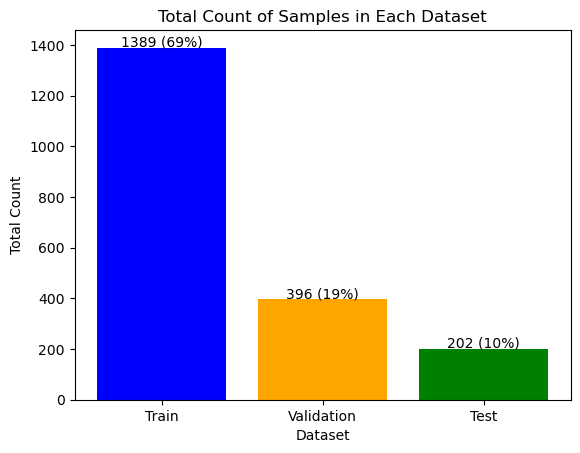

In [32]:
percent_train = (total_train / (total_train + total_validation + total_test)) * 100
percent_validation = (total_validation / (total_train + total_validation + total_test)) * 100
percent_test = (total_test / (total_train + total_validation + total_test)) * 100

# Plot the graph
labels = ['Train', 'Validation', 'Test']
counts = [total_train, total_validation, total_test]

plt.bar(labels, counts, color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Total Count')
plt.title('Total Count of Samples in Each Dataset')

# Add percentage annotations
for i, count in enumerate(counts):
    plt.text(i, count + 5, f'{counts[i]} ({int((counts[i] / (total_train + total_validation + total_test)) * 100)}%)', ha='center')

plt.show()

## Data Preprocessing

In [33]:
def preprocess_and_save_images(input_dir):
    # Loop through train, validation, and test folders
    for split_dir in ['train', 'validation', 'test']:
        categories = ['glass', 'metal', 'plastic', 'paper']
        for category_name in categories:
            category_input_dir = os.path.join(input_dir, split_dir, category_name)
            
            # Loop through all files in the current category directory
            for file_name in os.listdir(category_input_dir):
                # Check if the file is an image
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    # Construct the full path to the input image
                    input_path = os.path.join(category_input_dir, file_name)
                    
                    # Preprocess and save the image
                    try:
                        preprocess_and_save_image(input_path)
                    except Exception as e:
                        print(f"Error processing file '{file_name}': {e}")

def preprocess_and_save_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale if necessary
    if len(image.shape) == 3 and image.shape[2] == 3:  # Color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image to 32x32
    resized_image = cv2.resize(image, (128, 128))
    
    # Write the preprocessed image back to the same location
    cv2.imwrite(image_path, resized_image)

# Example usage
input_directory = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset"
preprocess_and_save_images(input_directory)

## Data Augmentation for Train Dataset only

In [34]:
def augment_images(input_dir, output_dir):
    # Loop through each category directory in the input directory
    for category_name in os.listdir(input_dir):
        category_input_dir = os.path.join(input_dir, category_name)
        category_output_dir = os.path.join(output_dir, category_name)
        
        # Create the output directory for the current category if it doesn't exist
        if not os.path.exists(category_output_dir):
            os.makedirs(category_output_dir)
        
        # Loop through all files in the current category directory
        for file_name in os.listdir(category_input_dir):
            # Check if the file is an image
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                # Construct the full path to the input image
                input_path = os.path.join(category_input_dir, file_name)
                
                # Preprocess and augment the image
                try:
                    augment_image(input_path, category_output_dir)
                except Exception as e:
                    print(f"Error processing file '{file_name}': {e}")

def augment_image(image_path, output_dir):
    # Read the image in grayscale
    image = cv2.imread(image_path)
    
    # Data augmentation
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),          # Flip horizontally
        iaa.MultiplySaturation((0.5, 1.5)),  # Vary saturation
        iaa.MultiplyBrightness((0.5, 1.5)),  # Vary brightness
        iaa.GammaContrast((0.5, 2.0))  # Vary exposure
    ], random_order=True)
    
    # Generate 4 augmented images
    images_aug = [seq.augment_image(image) for _ in range(4)]
    
    # Write the augmented images to output
    base_name = os.path.basename(image_path)
    image_name, image_ext = os.path.splitext(base_name)
    for i, augmented_image in enumerate(images_aug):
        output_path = os.path.join(output_dir, f"{image_name}_aug_{i}{image_ext}")
        cv2.imwrite(output_path, augmented_image)

# Example usage
input_directory = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\train"
output_directory = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\train"
augment_images(input_directory, output_directory)


In [35]:
def count_images_per_class(input_dir):
    # Dictionary to store the count of images per class for each folder
    class_counts = {'train': {}, 'validation': {}, 'test': {}}
    
    # Loop through each folder (train, validation, test)
    for folder_name in ['train', 'validation', 'test']:
        folder_dir = os.path.join(input_dir, folder_name)
        # Loop through each category directory in the current folder
        for category_name in os.listdir(folder_dir):
            category_dir = os.path.join(folder_dir, category_name)
            # Initialize count for current category in current folder
            class_counts[folder_name][category_name] = 0
            # Loop through all files in the current category directory
            for file_name in os.listdir(category_dir):
                # Check if the file is an image
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    # Increment count for current category in current folder
                    class_counts[folder_name][category_name] += 1
    
    return class_counts

# Example usage
input_directory = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset"
class_counts = count_images_per_class(input_directory)

# Print the counts for each class in each folder
print("Total images for each class in each folder:")
for folder_name, folder_counts in class_counts.items():
    print(f"\n{folder_name.capitalize()} folder:")
    for class_name, count in folder_counts.items():
        print(f"Total images in {class_name}: {count}")

Total images for each class in each folder:

Train folder:
Total images in glass: 1750
Total images in metal: 1435
Total images in paper: 2075
Total images in plastic: 1685

Validation folder:
Total images in glass: 100
Total images in metal: 82
Total images in paper: 118
Total images in plastic: 96

Test folder:
Total images in glass: 51
Total images in metal: 41
Total images in paper: 61
Total images in plastic: 49


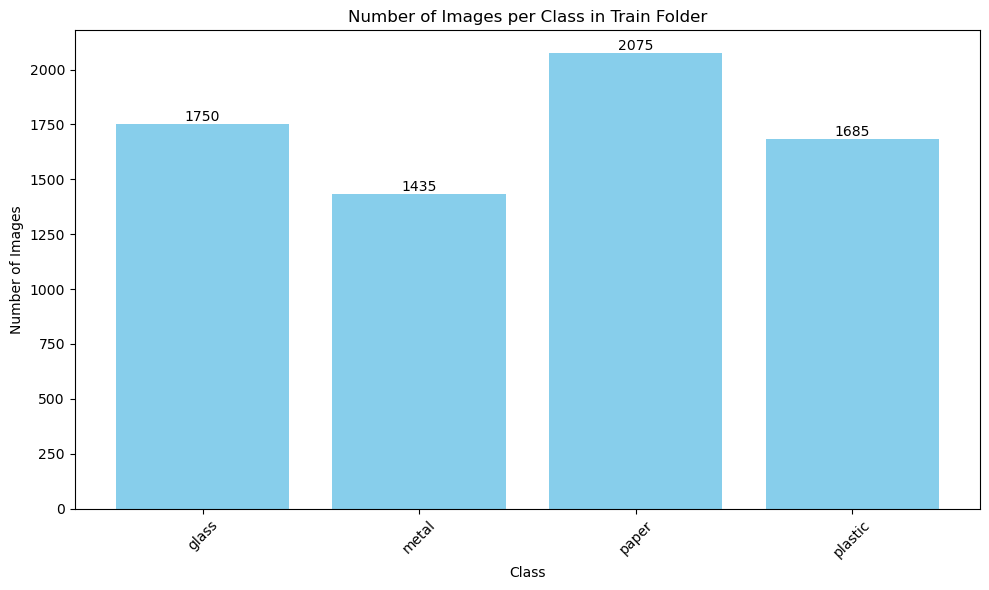

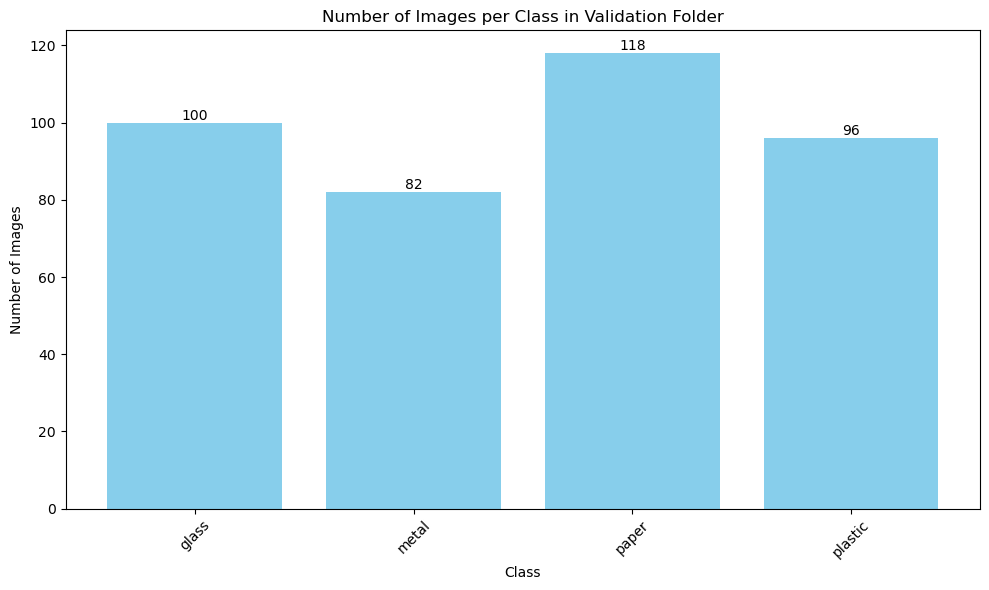

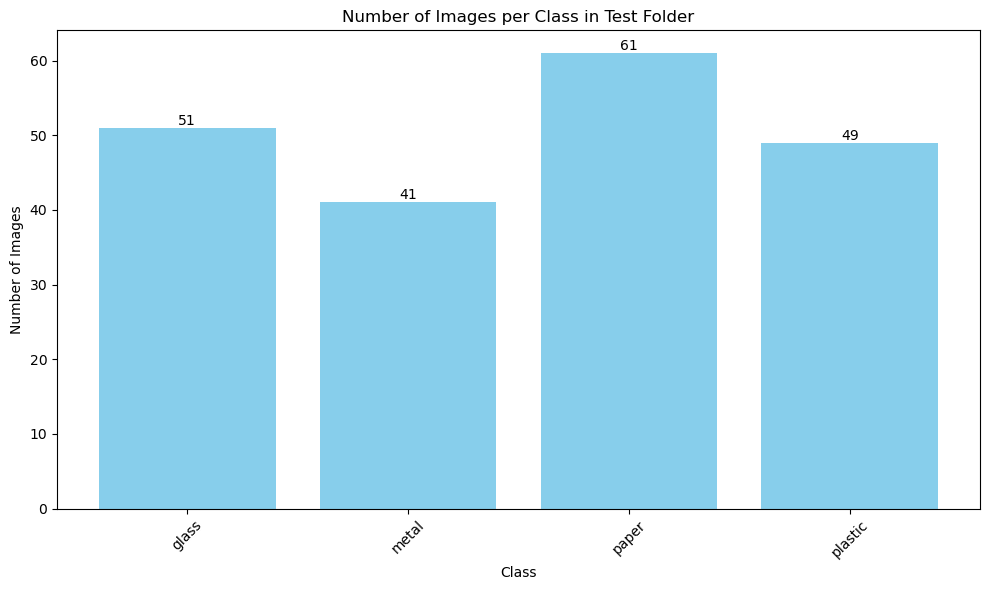

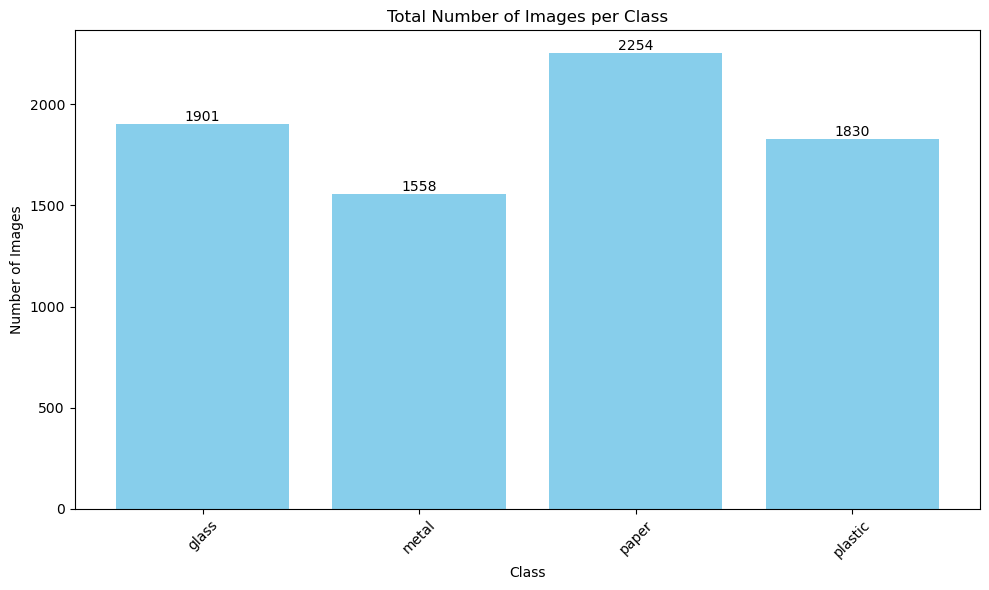

In [36]:
def plot_bar_graphs(class_counts):
    for folder_name, folder_counts in class_counts.items():
        plt.figure(figsize=(10, 6))
        bars = plt.bar(folder_counts.keys(), folder_counts.values(), color='skyblue')
        plt.xlabel('Class')
        plt.ylabel('Number of Images')
        plt.title(f'Number of Images per Class in {folder_name.capitalize()} Folder')
        plt.xticks(rotation=45)
        
        # Add text labels for each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

    # Plotting total
    total_counts = {}
    for folder_name, folder_counts in class_counts.items():
        for class_name, count in folder_counts.items():
            if class_name in total_counts:
                total_counts[class_name] += count
            else:
                total_counts[class_name] = count
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(total_counts.keys(), total_counts.values(), color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Total Number of Images per Class')
    plt.xticks(rotation=45)

    # Add text labels for each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Plot bar graphs
plot_bar_graphs(class_counts)

### Image Classification - CNN

In [68]:
PATH_TRAIN = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\train"
PATH_VALIDATION = r'C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\validation'
PATH_TEST = r"C:\Users\victo\Desktop\IS4242\Group Project\kaggle_dataset\test"

class_names = ['glass', 'metal','paper','plastic']

train_dir = os.path.join(PATH_TRAIN)
validation_dir = os.path.join(PATH_VALIDATION)
test_dir = os.path.join(PATH_TEST)

len(os.listdir(PATH_TRAIN))

4

In [69]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

#Normalise the Images
image_gen = ImageDataGenerator(rescale=1./255)

In [70]:
# Assuming you have multiple classes, set class_mode to 'categorical'
train_data_gen = image_gen.flow_from_directory(
    directory=train_dir, 
    shuffle=True, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="categorical")

validation_data_gen = image_gen.flow_from_directory(
    directory=validation_dir, 
    shuffle=True, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="categorical")


test_data_gen = image_gen.flow_from_directory(
    directory=test_dir, 
    shuffle=False, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="categorical")


Found 6945 images belonging to 4 classes.
Found 396 images belonging to 4 classes.
Found 202 images belonging to 4 classes.


In [71]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(4, activation='softmax')
])

batch_size = 45
epochs = 60
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

C:\Users\victo\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_294 (Conv2D)                  │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_295 (Conv2D)                  │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_296 (Conv2D)                  │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_297 (Conv2D)                  │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,300 (216.02 KB)

 Trainable params: 55,300 (216.02 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
batch_size = 45
epochs = 60

history = model.fit(
    train_data_gen,
    validation_data = validation_data_gen,
    steps_per_epoch= total_train // batch_size,
    epochs = epochs,
    validation_steps= total_validation // batch_size,
    callbacks = [tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.01,
                patience=7)]
)


Epoch 1/60


C:\Users\victo\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.2869 - loss: 1.3806 - val_accuracy: 0.2891 - val_loss: 1.3474
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.3499 - loss: 1.3103 - val_accuracy: 0.4143 - val_loss: 1.0641
Epoch 3/60
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.2500 - loss: 1.3322

C:\Users\victo\anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.3594 - loss: 1.2718 - val_accuracy: 0.3828 - val_loss: 1.2266
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.3900 - loss: 1.2313 - val_accuracy: 0.4429 - val_loss: 0.9970
Epoch 5/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.4401 - loss: 1.2219 - val_accuracy: 0.5039 - val_loss: 1.1910
Epoch 6/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.4746 - loss: 1.2118 - val_accuracy: 0.4857 - val_loss: 1.0247
Epoch 7/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.4345 - loss: 1.2329 - val_accuracy: 0.4531 - val_loss: 1.1992
Epoch 8/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3909 - loss: 1.1202 - val_accuracy: 0.4786 - val_loss: 0.9650
Epoch 9/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.4447 - loss: 1.1701 - val_accuracy: 0.4570 - val_loss: 1.1758
Epoch 10/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.4586 - loss: 1.1858 - val_accuracy: 0.3286 - val_

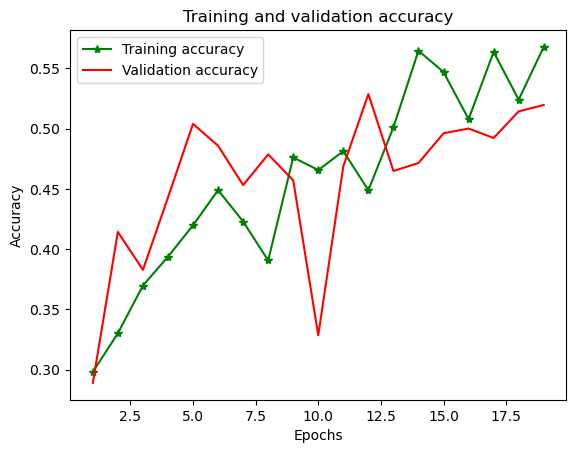

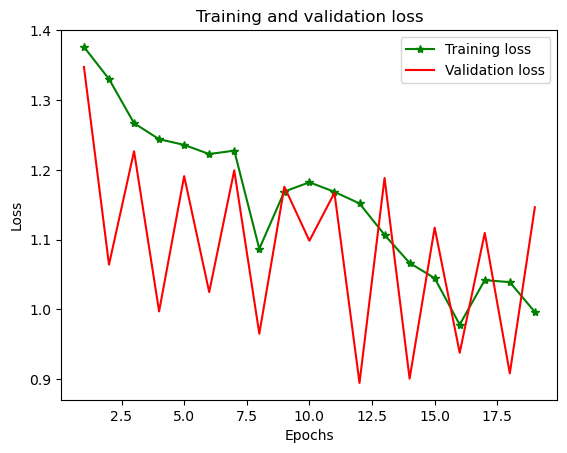

In [73]:
train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Classification Report:
              precision    recall  f1-score   support

       glass       0.45      0.59      0.51        51
       metal       0.45      0.34      0.39        41
       paper       0.62      0.46      0.53        61
     plastic       0.45      0.55      0.50        49

    accuracy                           0.49       202
   macro avg       0.49      0.48      0.48       202
weighted avg       0.50      0.49      0.49       202



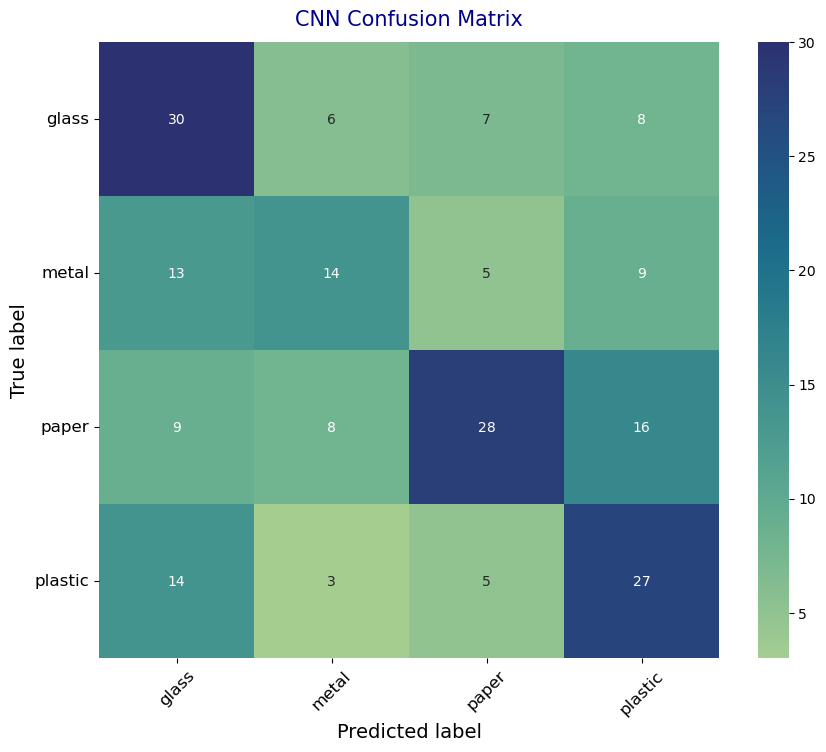

In [74]:
# Make predictions on the test dataset
y_pred = model.predict(test_data_gen)
y_true = test_data_gen.classes

# Get the class labels
class_labels = list(test_data_gen.class_indices.keys())

# Convert numeric labels to strings
y_true = [class_labels[label] for label in y_true]

# Convert predicted probabilities to class labels
y_pred_labels = [class_labels[i] for i in np.argmax(y_pred, axis=1)]

# Generate the classification report
report = classification_report(y_true, y_pred_labels, target_names=class_labels)

# Print the classification report
print("Classification Report:")
print(report)

# Generate and visualize confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Generate and visualize confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=class_labels, yticklabels=class_labels)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, fontsize=12)
plt.title('CNN Confusion Matrix', fontsize=15, pad=12, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [75]:
# to identify the accuracy of each class 
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Overall accuracy
print ("Glass Metal Paper Plastic")
ACC = (TP+TN)/(TP+FP+FN+TN)
print (ACC)

Glass Metal Paper Plastic
[0.71782178 0.78217822 0.75247525 0.72772277]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


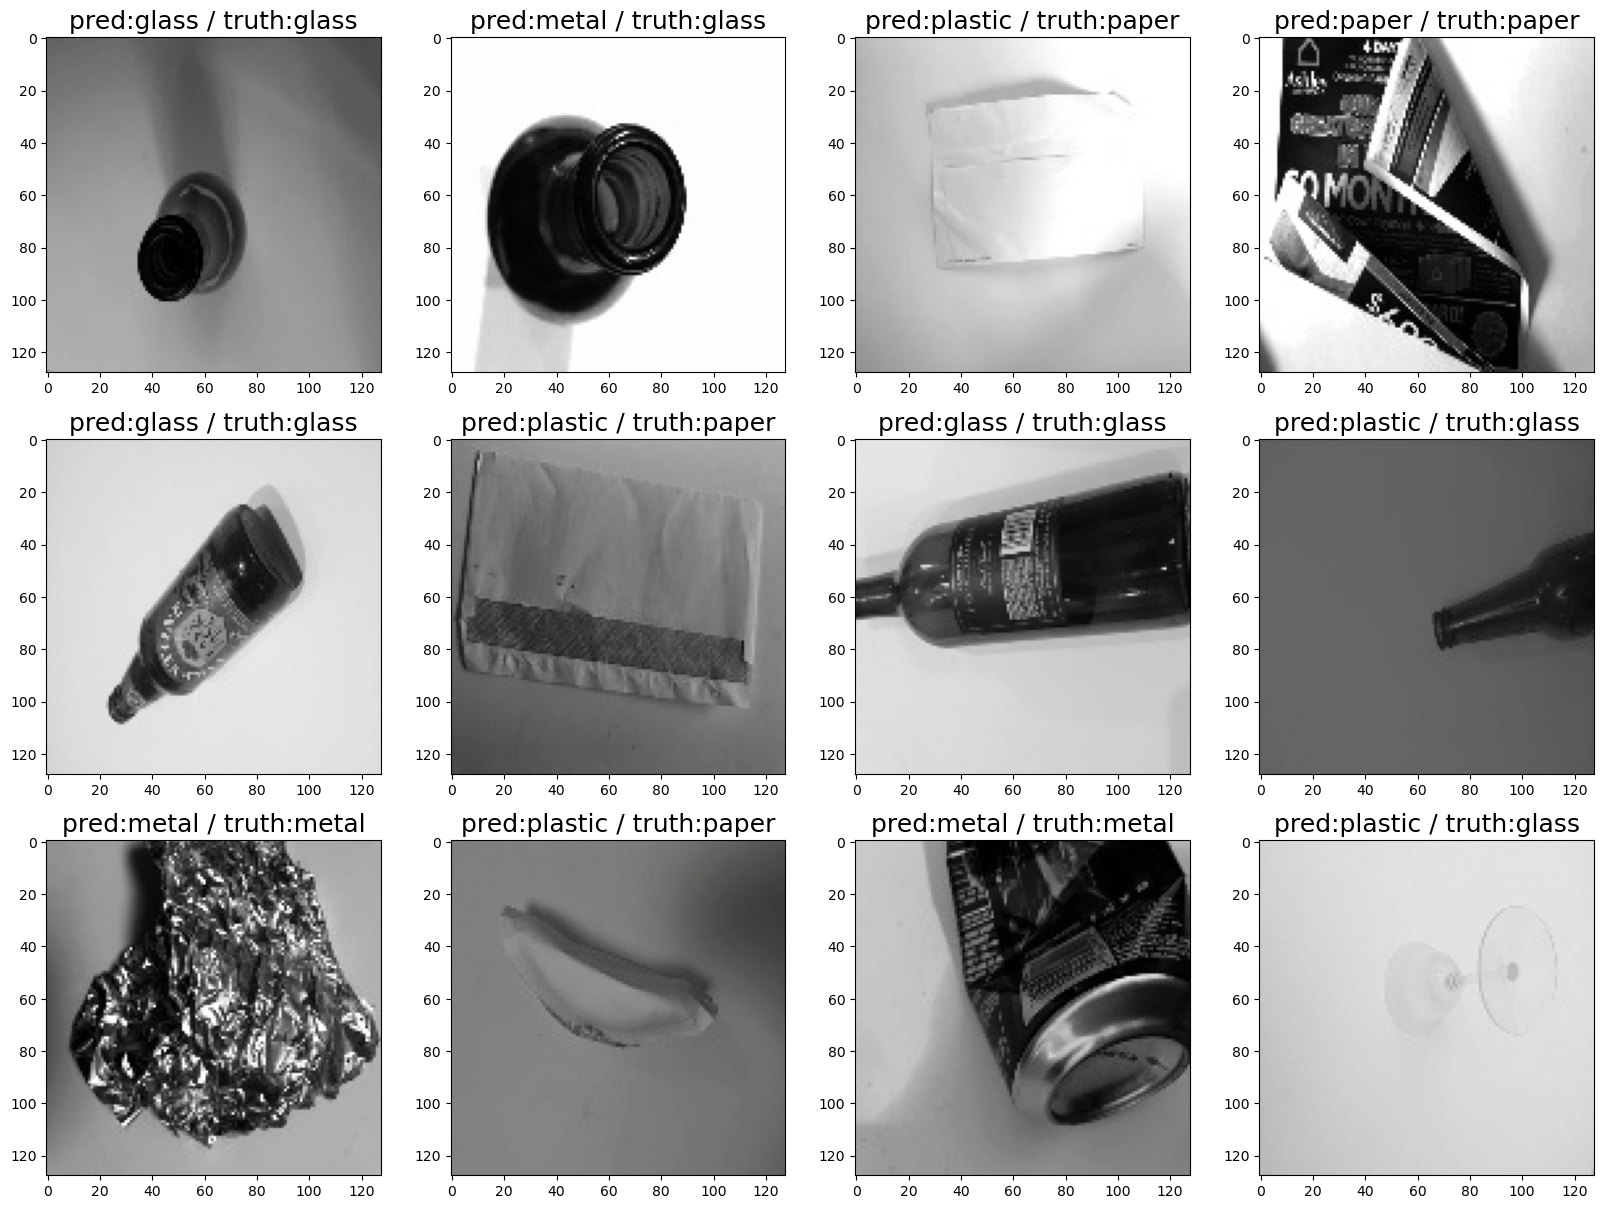

In [76]:
number_to_class = ['glass',\
                   'metal',
                   'paper',\
                   'plastic']

test_x, test_y = train_data_gen.__getitem__(1)
# test_x is used to train the data
# test_y refers to the actual answer of the testing set data
# preds refers to the predicted class
preds = model.predict(test_x)

plt.figure(figsize=(20, 20))
for i in range(12):
    plt.subplot(4,4, i+1)
    plt.title('pred:%s / truth:%s' % (number_to_class[np.argmax(preds[i])], number_to_class[np.argmax(test_y[i])]), size=18)
    plt.imshow(test_x[i])
#shows some testing results

## Using Pre-trained Model - InceptionV3

In [77]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the InceptionV3 model with weights trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes for classification

# Combine the base model and custom head to create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_298 (Conv2D)           │ (None, 63, 63, 32)        │             864 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_282       │ (None, 63, 63, 32)        │              96 │ conv2d_298[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_282 (Activation)   │ (None, 63, 63, 32)        │               0 │ batch_normalization_282[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_299 (Conv2D)           │ (None, 61, 61, 32)        │           9,216 │ activation_282[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_283       │ (None, 61, 61, 32)        │              96 │ conv2d_299[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_283 (Activation)   │ (None, 61, 61, 32)        │               0 │ batch_normalization_283[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_300 (Conv2D)           │ (None, 61, 61, 64)        │          18,432 │ activation_283[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_284       │ (None, 61, 61, 64)        │             192 │ conv2d_300[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_284 (Activation)   │ (None, 61, 61, 64)        │               0 │ batch_normalization_284[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_28              │ (None, 30, 30, 64)        │               0 │ activation_284[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_301 (Conv2D)           │ (None, 30, 30, 80)        │           5,120 │ max_pooling2d_28[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_285       │ (None, 30, 30, 80)        │             240 │ conv2d_301[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_285 (Activation)   │ (None, 30, 30, 80)        │               0 │ batch_normalization_285[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_302 (Conv2D)           │ (None, 28, 28, 192)       │         138,24

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [78]:
batch_size = 45
epochs = 60

history = model.fit(
    train_data_gen,
    validation_data = validation_data_gen,
    steps_per_epoch= total_train // batch_size,
    epochs = epochs,
    validation_steps= total_validation // batch_size,
    callbacks = [tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.01,
                patience=7)]
)

Epoch 1/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 311ms/step - accuracy: 0.3982 - loss: 6.7627 - val_accuracy: 0.5352 - val_loss: 1.2255
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.6350 - loss: 0.9452 - val_accuracy: 0.6571 - val_loss: 0.6726
Epoch 3/60
 1/30 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.5312 - loss: 0.8459

C:\Users\victo\anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.7067 - loss: 0.7078 - val_accuracy: 0.6992 - val_loss: 0.7621
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.7988 - loss: 0.5604 - val_accuracy: 0.7429 - val_loss: 0.6650
Epoch 5/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.7999 - loss: 0.5244 - val_accuracy: 0.6523 - val_loss: 0.8617
Epoch 6/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.7900 - loss: 0.5395 - val_accuracy: 0.7643 - val_loss: 0.5855
Epoch 7/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.8539 - loss: 0.3929 - val_accuracy: 0.7578 - val_loss: 0.7375
Epoch 8/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8612 - loss: 0.3365 - val_accuracy: 0.7286 - val_loss: 0.6248
Epoch 9/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.8889 - loss: 0.3105 - val_accuracy: 0.7344 - val_loss: 0.7563
Epoch 10/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.8695 - loss: 0.3576 - val_accuracy: 0.7500 - val_

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        51
           1       0.74      0.76      0.75        41
           2       0.88      0.95      0.91        61
           3       0.64      0.65      0.65        49

    accuracy                           0.75       202
   macro avg       0.74      0.74      0.74       202
weighted avg       0.75      0.75      0.75       202



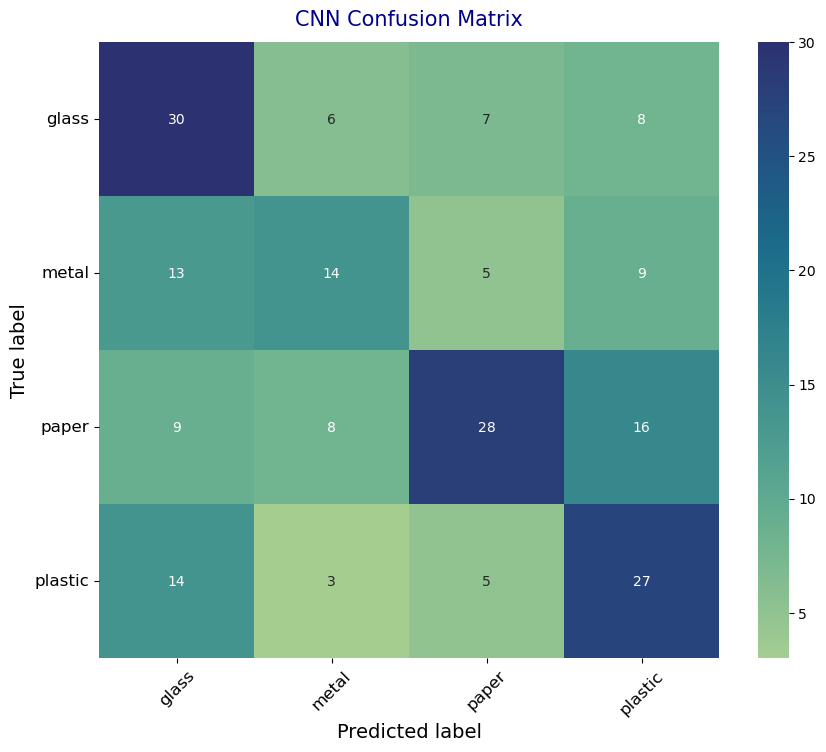

In [79]:
from sklearn.metrics import classification_report

# Predict the classes for the validation data
y_pred = model.predict(test_data_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true classes for the validation data
y_true_classes = test_data_gen.classes

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes)

# Print the classification report
print(report)

# Generate and visualize confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=class_labels, yticklabels=class_labels)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, fontsize=12)
plt.title('CNN Confusion Matrix', fontsize=15, pad=12, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [80]:
# to identify the accuracy of each class 
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Overall accuracy
print ("Glass Metal Paper Plastic")
ACC = (TP+TN)/(TP+FP+FN+TN)
print (ACC)

Glass Metal Paper Plastic
[0.71782178 0.78217822 0.75247525 0.72772277]


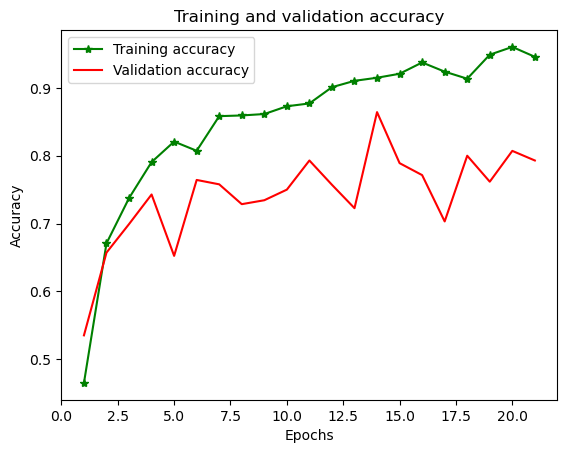

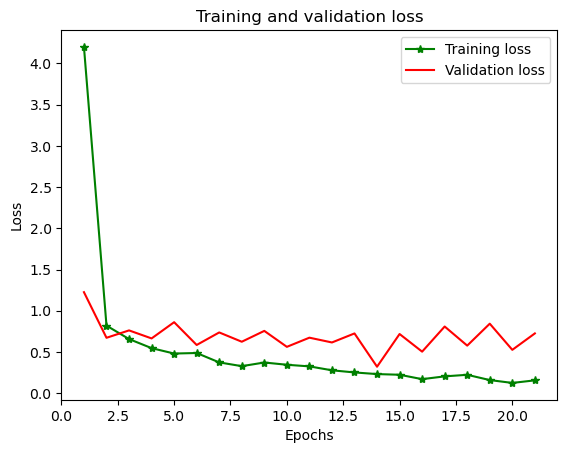

In [81]:
train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


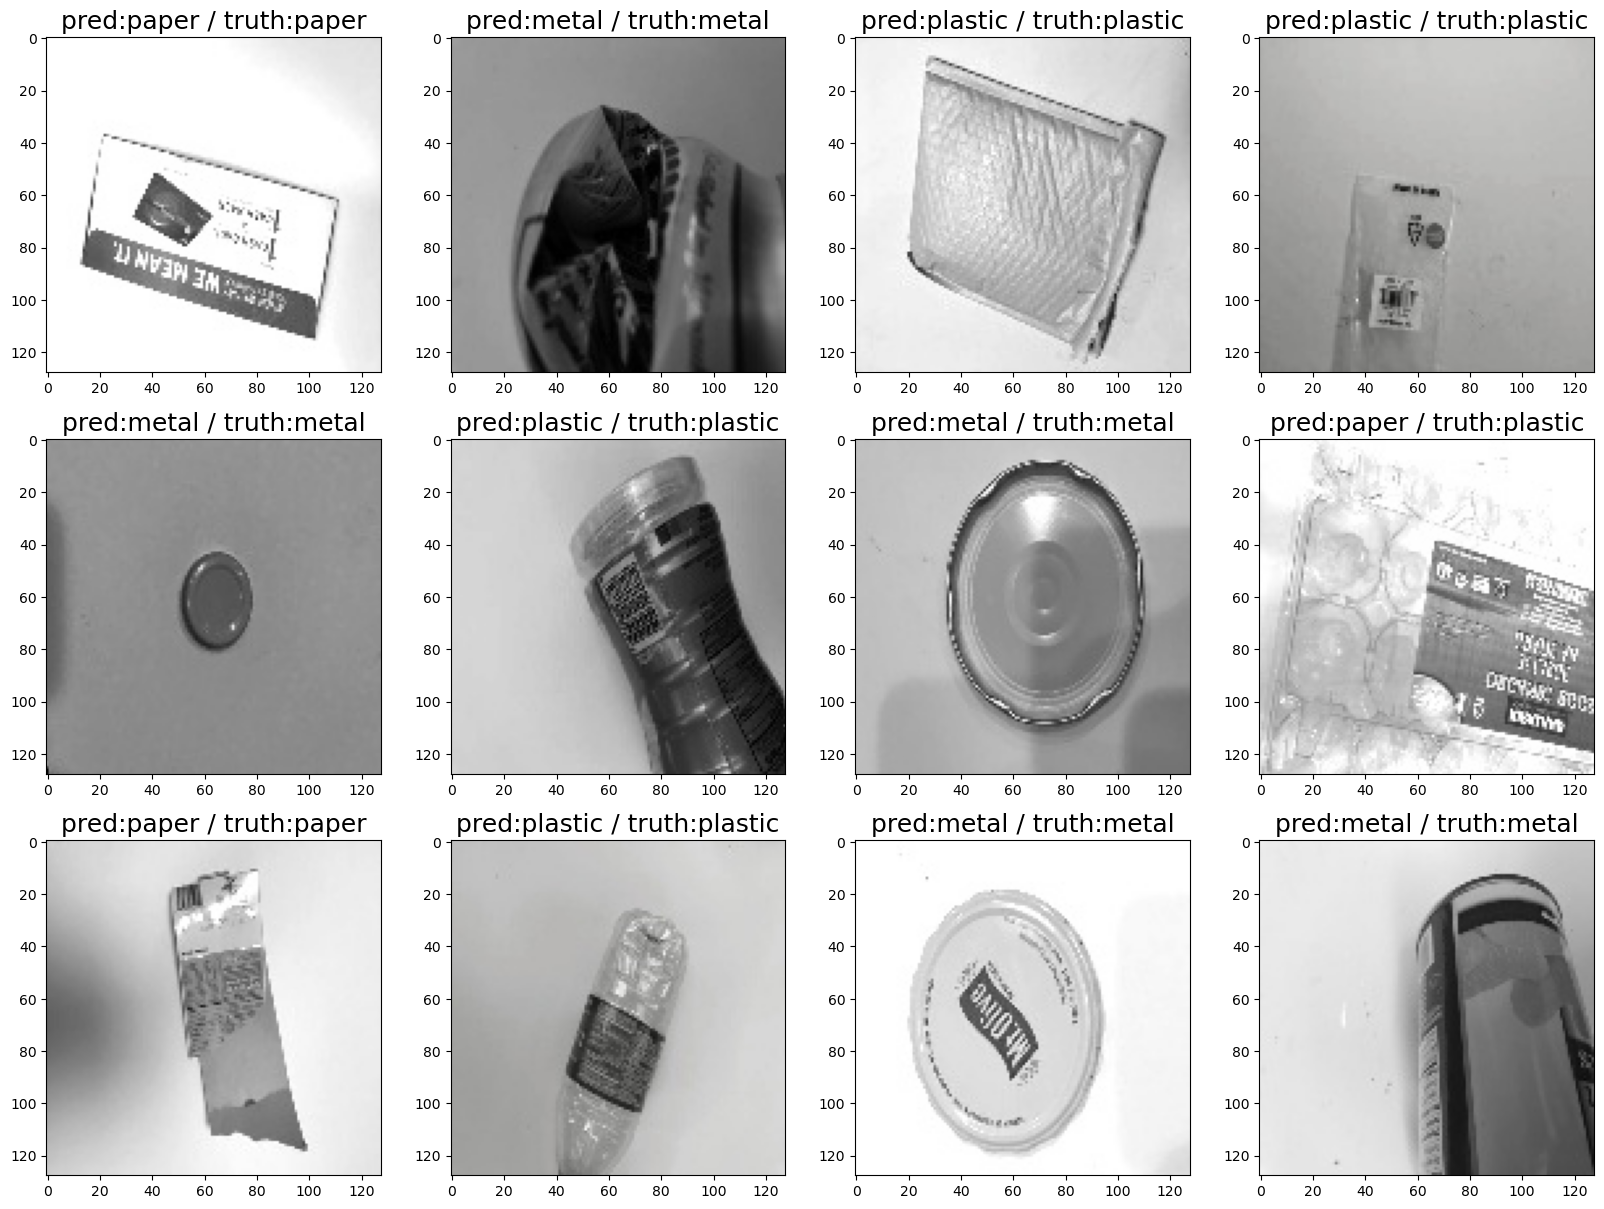

In [82]:
number_to_class = ['glass',\
                   'metal',
                   'paper',\
                   'plastic']

test_x, test_y = train_data_gen.__getitem__(1)
# test_x is used to train the data
# test_y refers to the actual answer of the testing set data
# preds refers to the predicted class
preds = model.predict(test_x)

plt.figure(figsize=(20, 20))
for i in range(12):
    plt.subplot(4,4, i+1)
    plt.title('pred:%s / truth:%s' % (number_to_class[np.argmax(preds[i])], number_to_class[np.argmax(test_y[i])]), size=18)
    plt.imshow(test_x[i])
#shows some testing results